In [2]:
# ============================================================
# 01 — Imports and Data Loading
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# XGBoost
from xgboost import XGBRegressor

# Load computed IV results
df = pd.read_csv("src/data/results/IV_results.csv")
df.head()


,strike,type,mid,spot,T,IV
0,500.0,call,183.840,683.630005,0.016438,NaN
1,585.0,call,98.930,683.630005,0.016438,0.505086
2,590.0,call,93.940,683.630005,0.016438,0.484983
3,610.0,call,73.975,683.630005,0.016438,0.398291
4,620.0,call,64.000,683.630005,0.016438,0.355365


In [3]:
# ============================================================
# 02 — Feature Engineering
# ============================================================

# Convert option type to binary (call=1, put=0)
df["type_bin"] = df["type"].apply(lambda x: 1 if x == "call" else 0)

# Moneyness: strike / spot
df["moneyness"] = df["strike"] / df["spot"]

# Distance to money: |strike - spot|
df["dist_to_money"] = abs(df["strike"] - df["spot"])

# Keep relevant features
features = ["strike", "spot", "T", "type_bin", "moneyness", "dist_to_money"]
target = "IV"

df_model = df.dropna(subset=[target])
X = df_model[features]
y = df_model[target]

df_model.head()


,strike,type,mid,spot,T,IV,type_bin,moneyness,dist_to_money
1,585.0,call,98.930,683.630005,0.016438,0.505086,1,0.855726,98.630005
2,590.0,call,93.940,683.630005,0.016438,0.484983,1,0.863040,93.630005
3,610.0,call,73.975,683.630005,0.016438,0.398291,1,0.892296,73.630005
4,620.0,call,64.000,683.630005,0.016438,0.355365,1,0.906923,63.630005
5,625.0,call,59.000,683.630005,0.016438,0.329605,1,0.914237,58.630005


In [4]:
# ============================================================
# 03 — Train/Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# ============================================================
# 04 — Scaling the Features
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# ============================================================
# 05 — Model 1: Linear Regression
# ============================================================

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)


In [7]:
# ============================================================
# 06 — Model 2: Random Forest Regressor
# ============================================================

rf = RandomForestRegressor(
    n_estimators=300, 
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)


In [8]:
# ============================================================
# 07 — Model 3: XGBoost Regressor
# ============================================================

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


In [9]:
# ============================================================
# 08 — Model Evaluation Function
# ============================================================

def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2 Score": r2_score(y_true, y_pred)
    }

results = []
results.append(evaluate_model("Linear Regression", y_test, lr_pred))
results.append(evaluate_model("Random Forest", y_test, rf_pred))
results.append(evaluate_model("XGBoost", y_test, xgb_pred))

results_df = pd.DataFrame(results)
results_df


,Model,MAE,RMSE,R2 Score
0,Linear Regression,0.016325,0.020739,0.924751
1,Random Forest,0.011009,0.020411,0.927112
2,XGBoost,0.007901,0.019284,0.934941


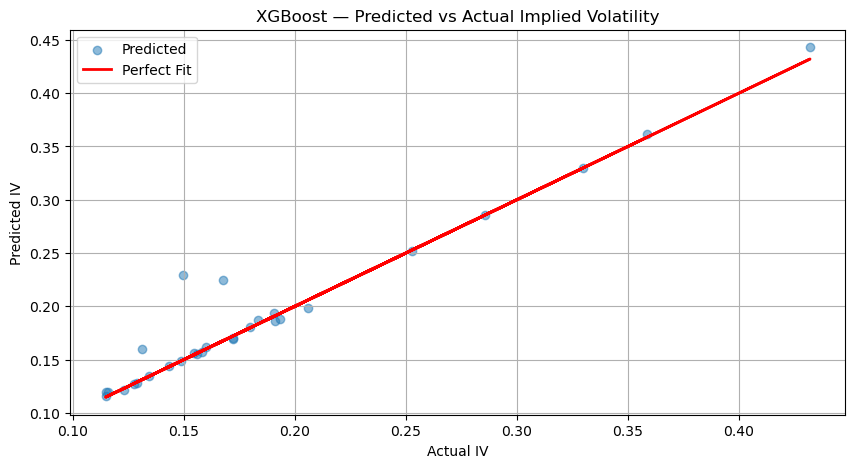

In [10]:
# ============================================================
# 09 — Visualization: Predicted vs Actual IV
# ============================================================

plt.figure(figsize=(10,5))
plt.scatter(y_test, xgb_pred, alpha=0.5, label="Predicted")
plt.plot(y_test, y_test, color='red', linewidth=2, label="Perfect Fit")

plt.xlabel("Actual IV")
plt.ylabel("Predicted IV")
plt.title("XGBoost — Predicted vs Actual Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# ============================================================
# 10 — Save Evaluation Table
# ============================================================

results_df.to_csv("src/data/results/model_performance.csv", index=False)
results_df


,Model,MAE,RMSE,R2 Score
0,Linear Regression,0.016325,0.020739,0.924751
1,Random Forest,0.011009,0.020411,0.927112
2,XGBoost,0.007901,0.019284,0.934941


In [13]:
plt.savefig("src/data/results/iv_prediction_fit.png", dpi=200)


<Figure size 640x480 with 0 Axes>